In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Plot parameters
sns.set()
# Seven hls color palette
current_palette_7 = sns.color_palette("hls", 7)
sns.set_palette(current_palette_7)

%pylab inline
pylab.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['xtick.major.size'] = 0
plt.rcParams['ytick.major.size'] = 0
# rcParams.keys()

Populating the interactive namespace from numpy and matplotlib


# Covariance matrix

The first thing to do to calculate the DSS is to compute the covariance matrices of our unbiased signal and of our filtered signal. The covariance matrix will summarize the variances of each vectors (the diagonal corresponds to the variance of one vector).

The formula of the covariance is the following:

$$cov(X,Y) = \sum_{i=1}^{N}\frac{(x_i-\bar{x})(y_i-\bar{y})}{N}$$

So it is the difference from the mean of the variable $\boldsymbol{y}$ weighted by the difference from the mean of the variable $\boldsymbol{y}$ added for each data point.

#### Example 1.

These variables can be in a matrix.

$
\boldsymbol{A}=
\begin{bmatrix}
    1 & 3 & 5\\\\
    5 & 4 & 1\\\\
    3 & 8 & 6
\end{bmatrix}
$

We will calculate the covariance of each column with each other. Let's start with column 1 and column 2:

$\boldsymbol{x} = \begin{bmatrix}
    1\\\\
    5\\\\
    3
\end{bmatrix}
$ and $\boldsymbol{y} = \begin{bmatrix}
    3\\\\
    4\\\\
    8
\end{bmatrix}$. So $\boldsymbol{\bar{x}}=3$, $\boldsymbol{\bar{y}}=5$ and $N=3$.

$cov(X,Y) = \frac{(1-3)(3-5)+(5-3)(4-5)+(3-3)(8-5)}{3}=\frac{2}{3}=0.6666$

In python/Numpy the covariance matrix can be calculated with the function `np.cov`. It is worth noting that if you want Numpy to use the columns as vectors, the parameter `rowvar=False` has to be used. Also, `bias=True` allow to divide by $N$ and not by $N-1$:

In [5]:
A = np.array([[1, 3, 5], [5, 4, 1], [3, 8, 6]])
print A
np.cov(A, rowvar=False, bias=True)

[[1 3 5]
 [5 4 1]
 [3 8 6]]


array([[ 2.66666667,  0.66666667, -2.66666667],
       [ 0.66666667,  4.66666667,  2.33333333],
       [-2.66666667,  2.33333333,  4.66666667]])

The covariance we calculated by hand concerned the first and the second columns. It thus corresponds to the cell (0,1) and (1,0) and we can see that the result is correct.

Another way to compute the covariance matrix is to center it around 0 (in order for each column to have a mean of 0), multiply it with its transpose and divide by the number of observation. Here is an implementation:

In [20]:
def calculateCovariance(X):
    X -= np.mean(X, axis = 0)
    covariance = X.T.dot(X)/3
    return covariance

Let's test it on our matrix $\boldsymbol{A}$:

In [21]:
calculateCovariance(A)

array([[ 95.17164106,  -4.4781596 ],
       [ -4.4781596 ,  87.95985266]])

We end up with the same results as before which is a good thing!

# Data visualization

Let's begin by writing a function to easily visualize the covariance matrix and the data. This function will first calculate the covariance matrix of our data and then plot it with the help of Seaborn and Matplotlib.

In [8]:
def plotDataAndCov(data):
    ACov = np.cov(data.T)
    print 'Covariance matrix:\n', ACov

    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(10, 10)

    plt.subplot(2, 2, 1)
    cmap = sns.color_palette("GnBu", 10)
    sns.heatmap(ACov, cmap=cmap, vmin=0)

    plt.subplot(2, 2, 2)
    plt.scatter(data[:,0], data[:,1], c=cmap[8])

# Uncorrelated data

Now that we have the plot function, we will generate some random data to visualize what the covariance matrices can tell us. We will start with data drawn from a normal distribution with the Numpy function `np.random.normal()`. This function need the mean, the standard deviation and the number of observations as input. We will create two random variables of 300 observations. If we draw two times 300 observations from a normal distribution, both vectors will be uncorrelated. We will need to transpose our matrix since the original shape is (2, 300) but we want the shape (300, 2).

Also, note that we use `np.random.seed` function for reproducibility.

In [9]:
np.random.seed(1234)
A = np.array([np.random.normal(2, 1, 300), np.random.normal(1, 1, 300)]).T
print A.shape

(300, 2)


Now we can plot our fake data and its covariance matrix with our function:

Covariance matrix:
[[ 0.95489941 -0.04493137]
 [-0.04493137  0.88254033]]


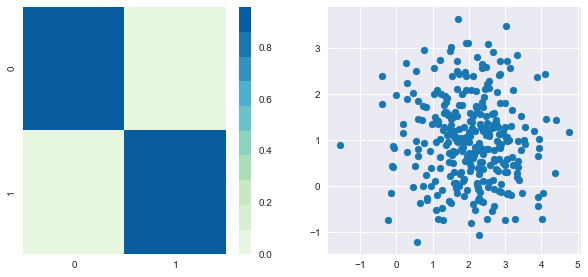

In [10]:
plotDataAndCov(A)

We can see that our two dimensions are uncorrelated. The covariance matrix shows that the variances of each variable is around 1 (we specified that in `np.random.normal` function) and the covariance of columns 1 and 2 is around 0. Since we insured that the two vectors are independant this is coherent (the oposite is not necessarly true: a covariance of 0 doesn't guaranty independancy (see [here](https://stats.stackexchange.com/questions/12842/covariance-and-independence)).

# Correlated data

Now, let's construct dependant data by specifying one column from the other one.

Covariance matrix:
[[ 0.95489941  0.93243372]
 [ 0.93243372  1.13060312]]


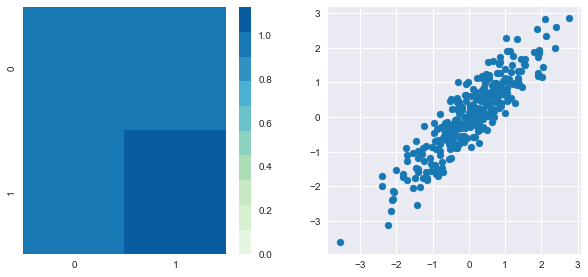

In [58]:
np.random.seed(1234)
b1 =  np.random.normal(0, 1, 300)
b2 = b1 + np.random.normal(0, 1, 300)/2.
B = np.array([b1, b2]).T
plotDataAndCov(B)

The correlation between the two dimensions is visible on the data plot. We can see that a line could be drawn and used to predict $\boldsymbol{y}$ from $\boldsymbol{x}$ and vice versa. The covariance matrix is not diagonal (there is non-zero cells outside of the diagonal) and that means that the covariance between dimensions is non-zero.

# Whitening

Different steps are needed to whiten our matrix:

    1- Zero-center the data
    2- Decorrelated the data
    3- Whiten the data
    
## 1. Zero-center the data

*Note:* this is important to `copy()` the input data in the function because in Python everything is a reference. Since we don't want to modify the input data with our function we have to explicitely copy it.

In [12]:
def centerData(X):
    X = X.copy()
    X -= np.mean(X, axis = 0)
    return X

Let's check that this is working:

Covariance matrix:
[[ 0.95489941 -0.04493137]
 [-0.04493137  0.88254033]]
Covariance matrix:
[[ 0.95489941 -0.04493137]
 [-0.04493137  0.88254033]]


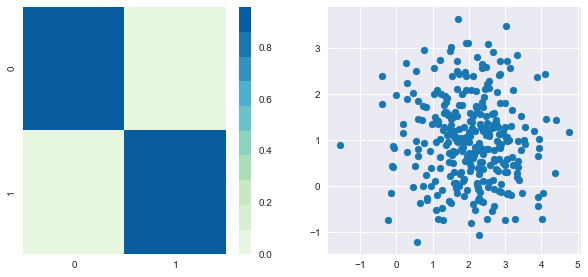

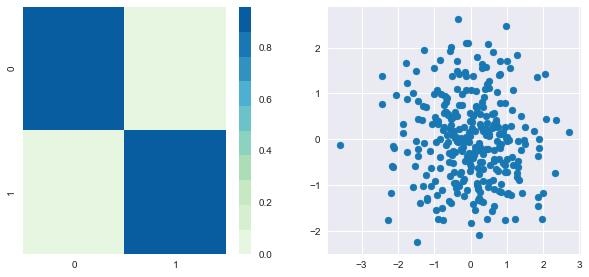

In [13]:
plotDataAndCov(A)
plotDataAndCov(centerData(A))

So far so good!

## 2. Decorrelated the data

At this point, we need to **decorrelate** our data. We can do this if we project it on the eigenvectors basis. This will rotate the data in order to avoid correlation. Here are the steps:

    1- Calculate the covariance matrix
    2- Calculate the eigenvectors of the covariance matrix
    3- Apply the data to the matrix of eigenvectors (this will rotate the data)
    
Here is the function:

In [48]:
import time
def decorrelate(X):
    cov = X.T.dot(X)
    eigVals, eigVecs = np.linalg.eig(cov)
    decorrelated = X.dot(eigVecs)
    return decorrelated

Let's try to decorrelate our matrix B (the one that presented a correlation) to see what are the graphical meaning:

Covariance matrix:
[[  1.06188081e-01  -3.60413946e-05]
 [ -3.60413946e-05   1.97931445e+00]]


(-5, 5)

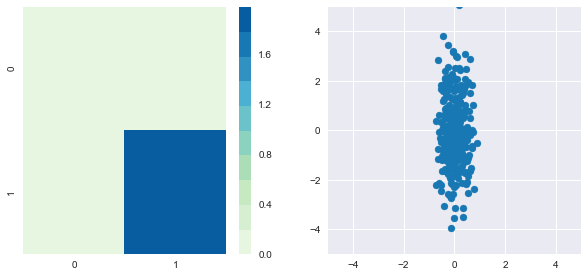

In [49]:
decorrelated_B = decorrelate(B)
plotDataAndCov(decorrelated_B)
plt.xlim(-5,5)
plt.ylim(-5,5)

We can see that the correlation is not here anymore and that the covariance matrix shows that the covariance between the two dimensions are equal to 0 (covariance is now a diagonal matrix). For more details about the eigendecomposition, see [this notebook]().

## 3. Whiten the data

The next step to whiten the data is to scale the uncorrelated matrix in order to obtain a covariance matrix corresponding to the identity matrix. To do that we scale our decorrelated data by dividing each dimension by the square-root of its corresponding eigenvalue.

*Note:* we add a small value (here $10^{-5}$) to avoid the division by $0$.

Covariance matrix:
[[  1.00324693e+00  -7.87854436e-05]
 [ -7.87854436e-05   1.00108631e+00]]


(-5, 5)

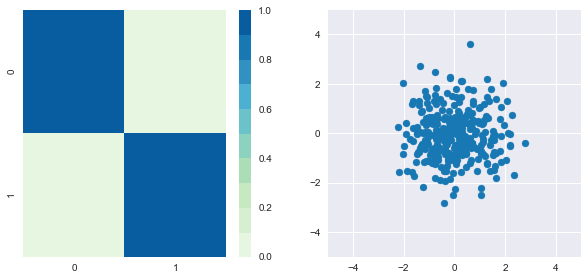

In [82]:
def whiten(X):
    cov = X.T.dot(X)/float(X.shape[0])
    eigVals, eigVecs = np.linalg.eig(cov)
    decorrelated = X.dot(eigVecs)
#     whitened = decorrelated/np.sqrt(eigVals+1e-5)
    # This can also be done with:
    whitened = np.diag(1/np.sqrt(eigVals+1e-5)).dot(decorrelated.T)
    return whitened.T

plotDataAndCov(whiten(B))
plt.xlim(-5,5)
plt.ylim(-5,5)

We can see that with the covariance matrix that this is all good. We have something that really look to the identity matrix ($1$ on the diagonal and $0$ elsewhere).

In [75]:
whitened_B = whiten(B)
whitened_B_cov = whitened_B.T.dot(whitened_B)/whitened_B.shape[0]

plotDataAndCov(whitened_B)
plt.xlim(-5,5)
plt.ylim(-5,5)

array([[  9.99905522e-01,   1.99840144e-16],
       [  1.99840144e-16,   9.99994942e-01]])

# References

[CS231 - Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/neural-networks-2/)

[Dustin Stansbury - The Clever Machine](https://theclevermachine.wordpress.com/2013/03/30/the-statistical-whitening-transform/)

[Cheveigné, A. de, & Parra, L. C. (2014). Joint decorrelation, a versatile tool for multichannel data analysis. NeuroImage, 98(Supplement C), 487–505.](https://doi.org/10.1016/j.neuroimage.2014.05.068)

[Cheveigné, A. de, & Arzounian, D. (2015). Scanning for oscillations. Journal of Neural Engineering, 12(6), 66020.](https://doi.org/10.1088/1741-2560/12/6/066020)


In [ ]:
A = np.array([[6, 1], [2, 7]])
eigenVals, eigenVecs = np.linalg.eig(A)
# Get the index of the sorted eigenvalues
idx1 = np.argsort(eigenVals.T)[::-1]
# Sort the eigenvalues in descending order
eigenVals = np.sort(eigenVals.T)[::-1]
# Reorder the columns of eigenvectors (the top components are the first columns)
PCAComp = eigenVecs[:,idx1]

In [ ]:
def whiten(X,fudge=1E-18):
   # the matrix X should be observations-by-components

   # get the covariance matrix
   Xcov = np.dot(X.T,X)

   # eigenvalue decomposition of the covariance matrix
   d, V = np.linalg.eigh(Xcov)

   # a fudge factor can be used so that eigenvectors associated with
   # small eigenvalues do not get overamplified.
   D = np.diag(1. / np.sqrt(d+fudge))

   # whitening matrix
   W = np.dot(np.dot(V, D), V.T)

   # multiply by the whitening matrix
   X_white = np.dot(X, W)

   return X_white, W

whiten(A)[0].dot(whiten(A)[0].T)

In [ ]:
def whitening(data):
    cov = data.T.dot(data)
    eigVals, eigVecs = np.linalg.eig(cov)
    N = np.diag(np.sqrt(1./eigVals))
    whitening = eigVecs.dot(N).dot(eigVecs.T)
    whitening = data.dot(whitening)
    return whitening

# Biased and unbiased covariance matrices

The denoising source separation works by finding weights that optimize one aspect of the signal. This aspect is represented in the biased data. This data can for instance be a narrow-band filtered version of the signal. In this case the weigths found are those that maximize the power of the signal at the frequency of the filter.

Figures of biased and unbiased signals.